In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#### Decripción del Problema

Fraude con tarjetas de crédito: análisis y prevención.

El fraude con tarjetas de crédito representa una amenaza significativa para la integridad de las transacciones financieras y la confianza de los consumidores en el comercio digital. A medida que la dependencia de las tarjetas de crédito para las compras diarias continúa creciendo, también lo hace la sofisticación de los estafadores que explotan las vulnerabilidades del sistema. Este proyecto tiene como objetivo analizar los patrones de fraude con tarjetas de crédito, comprender los factores que contribuyen a las actividades fraudulentas y explorar métodos efectivos para la detección y prevención.

#### Credit Card Fraud Dataset

El **Credit Card Fraud Dataset** es un conjunto de datos que comprende 100000 transacciones generadas para simular la actividad de las tarjetas de crédito en el mundo real. Cada entrada incluye las siguientes características:

- **TransactionID**:  Un identificador único para cada transacción, que garantiza la trazabilidad.
- **TransactionDate**: la fecha y hora en que se produjo la transacción, lo que permite el análisis temporal.
- **Amount**: el valor monetario de la transacción, que puede ayudar a identificar transacciones inusualmente grandes que pueden indicar fraude.
- **MerchantID**: Un identificador para el comerciante involucrado en la transacción, útil para evaluar patrones de fraude relacionados con el comerciante.
- **TransactionType**: indica si la transacción fue una compra o un reembolso, proporcionando contexto para la actividad.
- **Location**: La ubicación geográfica de la transacción, lo que facilita el análisis de las tendencias de fraude por región.
- **IsFraud**: una variable objetivo binaria que indica si la transacción es fraudulenta (1) o legítima (0), esencial para los modelos de aprendizaje supervisado.

In [53]:
data = pd.read_csv("./data/credit_card_fraud_dataset.csv")
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [54]:
print(data.shape[0], "transacciones.")

100000 transacciones.


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [56]:
data.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


In [57]:
#Verificaión de valores nulos
data.isnull().sum()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

#### Proporción de transacciones fraudulentas vs. legítimas

**Balance de clases (IsFraud):**
- ¿Cuántas transacciones son fraudulentas (1) vs. legítimas (0)?
- Si hay desbalance extremo (ej: 99% legítimas, 1% fraudulentas), se necesitarán técnicas como SMOTE o undersampling.

IsFraud
0    99000
1     1000
Name: count, dtype: int64


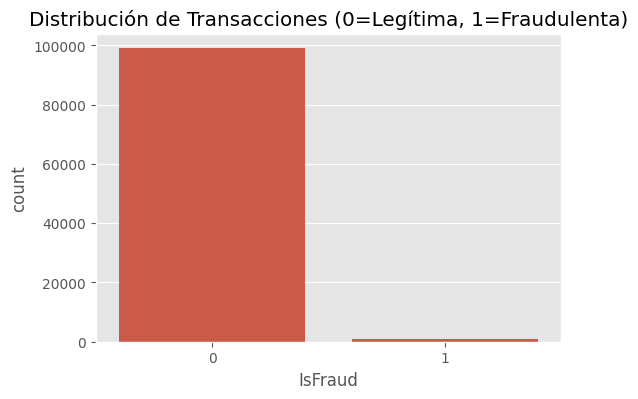

In [58]:
print(data['IsFraud'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='IsFraud', data=data)
plt.title('Distribución de Transacciones (0=Legítima, 1=Fraudulenta)')
plt.show()

#### Distribución de los importes y tipos de transacciones

**Análisis de montos (Amount):**
- ¿Hay diferencias significativas entre montos de transacciones fraudulentas y legítimas?
- ¿Existen valores atípicos (outliers) que puedan indicar posibles fraudes?

**Tipos de transacción (TransactionType):***
- ¿Hay algún tipo de transacción (compra, reembolso) más asociado al fraude?
- ¿Cuál es la distribución de tipos de transacción en general?

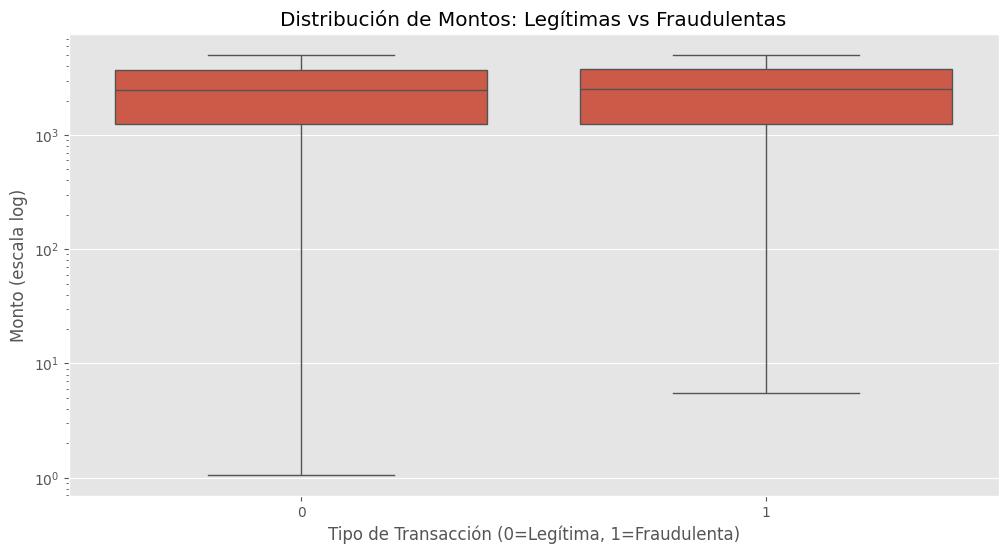

In [65]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='IsFraud', y='Amount', data=data)
plt.title('Distribución de Montos: Legítimas vs Fraudulentas')
plt.ylabel('Monto (escala log)')
plt.xlabel('Tipo de Transacción (0=Legítima, 1=Fraudulenta)')
plt.yscale('log')  # Usamos escala logarítmica para mejor visualización
plt.show()

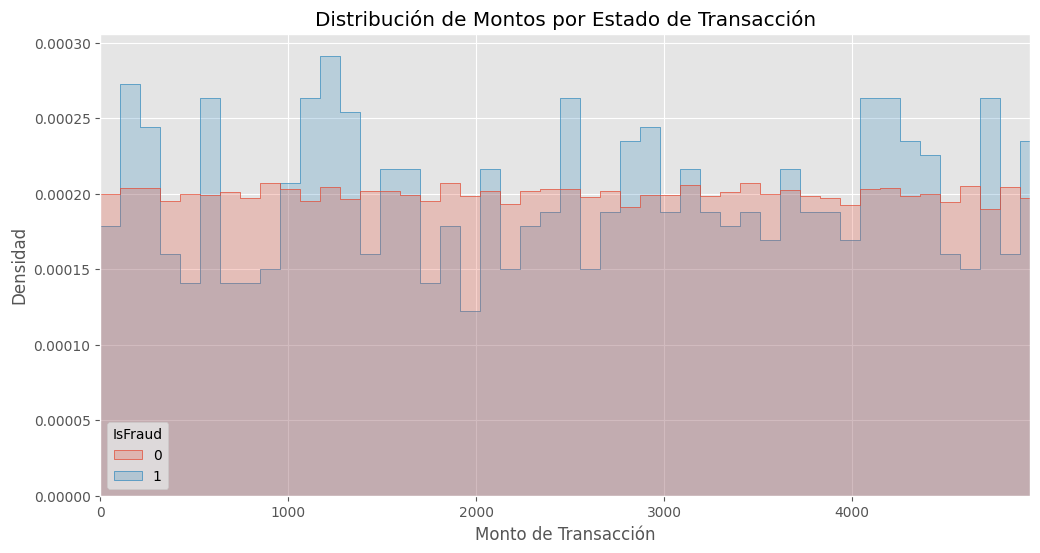

In [66]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Amount', hue='IsFraud', element='step', stat='density', common_norm=False)
plt.title('Distribución de Montos por Estado de Transacción')
plt.xlabel('Monto de Transacción')
plt.ylabel('Densidad')
plt.xlim(0, data['Amount'].quantile(0.99))  # Excluimos el 1% superior para mejor visualización
plt.show()

#### Identificar tendencias en fechas y ubicaciones

**Análisis temporal (TransactionDate):**
- ¿Hay patrones horarios, diarios o mensuales en las transacciones fraudulentas?
- ¿Ocurren más fraudes en ciertos días de la semana o en horarios nocturnos?

**Análisis geográfico (Location):**
- ¿Hay ciudades con mayor incidencia de fraudes?
- ¿Existen ubicaciones sospechosas con transacciones inusuales?


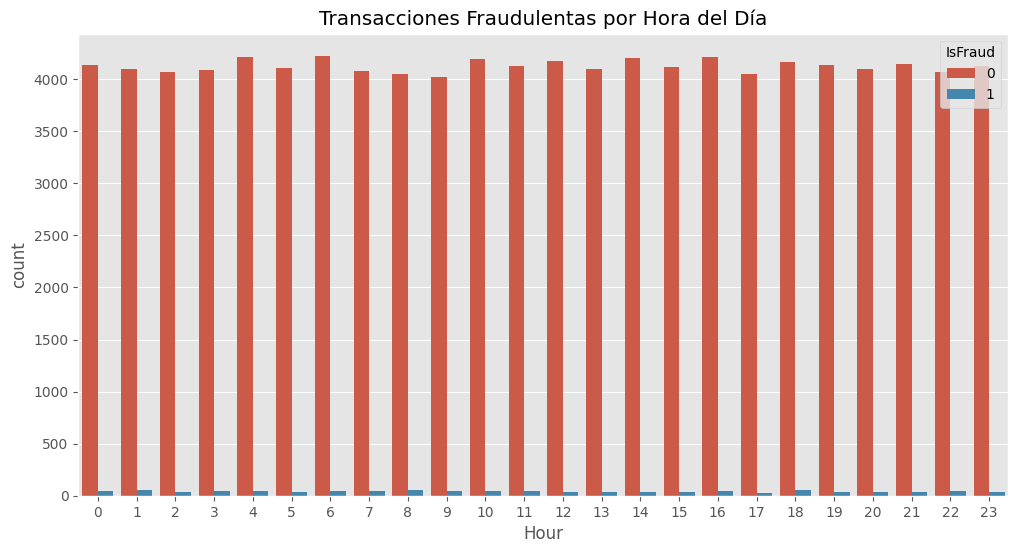

In [62]:
# Convertir a datetime y extraer características temporales
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Hour'] = data['TransactionDate'].dt.hour
data['DayOfWeek'] = data['TransactionDate'].dt.day_name()
data['Month'] = data['TransactionDate'].dt.month_name()

# Fraudes por hora del día
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', hue='IsFraud', data=data)
plt.title('Transacciones Fraudulentas por Hora del Día')
plt.show()

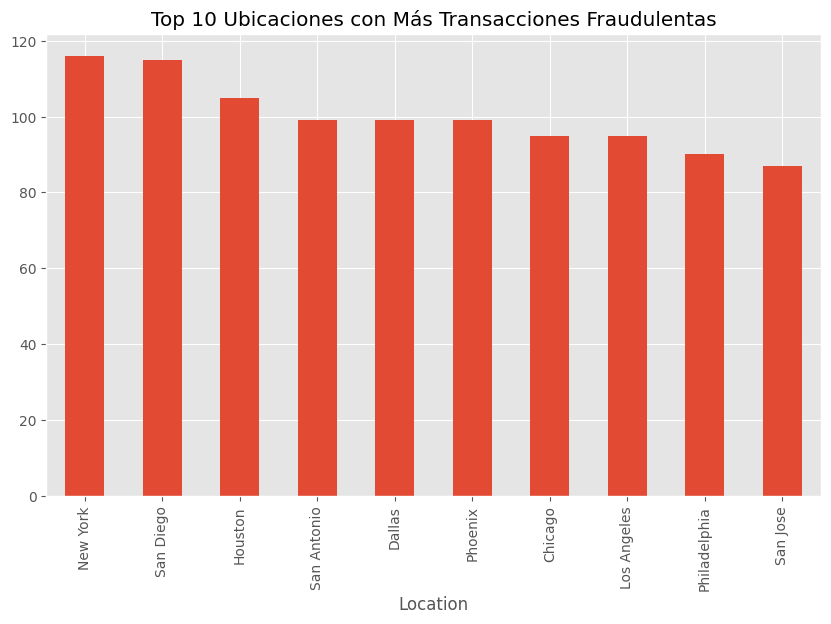

In [63]:
# Top 10 ubicaciones con más fraudes
fraud_by_location = data[data['IsFraud']==1]['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
fraud_by_location.plot(kind='bar')
plt.title('Top 10 Ubicaciones con Más Transacciones Fraudulentas')
plt.show()